In [25]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


import sys
sys.path.append('../src')

from src.testing.fixtures import CorrelationFactory

%matplotlib inline
plt.style.use('ggplot')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 20,10

In [26]:
from src.data.clean import *

In [27]:
x = np.random.normal(size=(10000, 1000))
eval0, evec0 = get_pca(np.corrcoef(x, rowvar=False))
mp = MarcenkoPastur(1., q=x.shape[0]/float(x.shape[1]), points=1000)
pdf0 = mp.pdf()
pdf1 = fit_kde(np.diag(eval0), bandwidth=0.01, x=mp.eigen_values)

ValueError: Expected 2D array, got 1D array instead:
array=[0.46754447 0.46881065 0.47007682 0.471343   0.47260918 0.47387535
 0.47514153 0.47640771 0.47767389 0.47894006 0.48020624 0.48147242
 0.48273859 0.48400477 0.48527095 0.48653713 0.4878033  0.48906948
 0.49033566 0.49160184 0.49286801 0.49413419 0.49540037 0.49666654
 0.49793272 0.4991989  0.50046508 0.50173125 0.50299743 0.50426361
 0.50552979 0.50679596 0.50806214 0.50932832 0.51059449 0.51186067
 0.51312685 0.51439303 0.5156592  0.51692538 0.51819156 0.51945773
 0.52072391 0.52199009 0.52325627 0.52452244 0.52578862 0.5270548
 0.52832098 0.52958715 0.53085333 0.53211951 0.53338568 0.53465186
 0.53591804 0.53718422 0.53845039 0.53971657 0.54098275 0.54224893
 0.5435151  0.54478128 0.54604746 0.54731363 0.54857981 0.54984599
 0.55111217 0.55237834 0.55364452 0.5549107  0.55617687 0.55744305
 0.55870923 0.55997541 0.56124158 0.56250776 0.56377394 0.56504012
 0.56630629 0.56757247 0.56883865 0.57010482 0.571371   0.57263718
 0.57390336 0.57516953 0.57643571 0.57770189 0.57896807 0.58023424
 0.58150042 0.5827666  0.58403277 0.58529895 0.58656513 0.58783131
 0.58909748 0.59036366 0.59162984 0.59289601 0.59416219 0.59542837
 0.59669455 0.59796072 0.5992269  0.60049308 0.60175926 0.60302543
 0.60429161 0.60555779 0.60682396 0.60809014 0.60935632 0.6106225
 0.61188867 0.61315485 0.61442103 0.61568721 0.61695338 0.61821956
 0.61948574 0.62075191 0.62201809 0.62328427 0.62455045 0.62581662
 0.6270828  0.62834898 0.62961515 0.63088133 0.63214751 0.63341369
 0.63467986 0.63594604 0.63721222 0.6384784  0.63974457 0.64101075
 0.64227693 0.6435431  0.64480928 0.64607546 0.64734164 0.64860781
 0.64987399 0.65114017 0.65240635 0.65367252 0.6549387  0.65620488
 0.65747105 0.65873723 0.66000341 0.66126959 0.66253576 0.66380194
 0.66506812 0.66633429 0.66760047 0.66886665 0.67013283 0.671399
 0.67266518 0.67393136 0.67519754 0.67646371 0.67772989 0.67899607
 0.68026224 0.68152842 0.6827946  0.68406078 0.68532695 0.68659313
 0.68785931 0.68912549 0.69039166 0.69165784 0.69292402 0.69419019
 0.69545637 0.69672255 0.69798873 0.6992549  0.70052108 0.70178726
 0.70305343 0.70431961 0.70558579 0.70685197 0.70811814 0.70938432
 0.7106505  0.71191668 0.71318285 0.71444903 0.71571521 0.71698138
 0.71824756 0.71951374 0.72077992 0.72204609 0.72331227 0.72457845
 0.72584463 0.7271108  0.72837698 0.72964316 0.73090933 0.73217551
 0.73344169 0.73470787 0.73597404 0.73724022 0.7385064  0.73977257
 0.74103875 0.74230493 0.74357111 0.74483728 0.74610346 0.74736964
 0.74863582 0.74990199 0.75116817 0.75243435 0.75370052 0.7549667
 0.75623288 0.75749906 0.75876523 0.76003141 0.76129759 0.76256377
 0.76382994 0.76509612 0.7663623  0.76762847 0.76889465 0.77016083
 0.77142701 0.77269318 0.77395936 0.77522554 0.77649171 0.77775789
 0.77902407 0.78029025 0.78155642 0.7828226  0.78408878 0.78535496
 0.78662113 0.78788731 0.78915349 0.79041966 0.79168584 0.79295202
 0.7942182  0.79548437 0.79675055 0.79801673 0.79928291 0.80054908
 0.80181526 0.80308144 0.80434761 0.80561379 0.80687997 0.80814615
 0.80941232 0.8106785  0.81194468 0.81321085 0.81447703 0.81574321
 0.81700939 0.81827556 0.81954174 0.82080792 0.8220741  0.82334027
 0.82460645 0.82587263 0.8271388  0.82840498 0.82967116 0.83093734
 0.83220351 0.83346969 0.83473587 0.83600205 0.83726822 0.8385344
 0.83980058 0.84106675 0.84233293 0.84359911 0.84486529 0.84613146
 0.84739764 0.84866382 0.84992999 0.85119617 0.85246235 0.85372853
 0.8549947  0.85626088 0.85752706 0.85879324 0.86005941 0.86132559
 0.86259177 0.86385794 0.86512412 0.8663903  0.86765648 0.86892265
 0.87018883 0.87145501 0.87272119 0.87398736 0.87525354 0.87651972
 0.87778589 0.87905207 0.88031825 0.88158443 0.8828506  0.88411678
 0.88538296 0.88664913 0.88791531 0.88918149 0.89044767 0.89171384
 0.89298002 0.8942462  0.89551238 0.89677855 0.89804473 0.89931091
 0.90057708 0.90184326 0.90310944 0.90437562 0.90564179 0.90690797
 0.90817415 0.90944033 0.9107065  0.91197268 0.91323886 0.91450503
 0.91577121 0.91703739 0.91830357 0.91956974 0.92083592 0.9221021
 0.92336827 0.92463445 0.92590063 0.92716681 0.92843298 0.92969916
 0.93096534 0.93223152 0.93349769 0.93476387 0.93603005 0.93729622
 0.9385624  0.93982858 0.94109476 0.94236093 0.94362711 0.94489329
 0.94615947 0.94742564 0.94869182 0.949958   0.95122417 0.95249035
 0.95375653 0.95502271 0.95628888 0.95755506 0.95882124 0.96008741
 0.96135359 0.96261977 0.96388595 0.96515212 0.9664183  0.96768448
 0.96895066 0.97021683 0.97148301 0.97274919 0.97401536 0.97528154
 0.97654772 0.9778139  0.97908007 0.98034625 0.98161243 0.98287861
 0.98414478 0.98541096 0.98667714 0.98794331 0.98920949 0.99047567
 0.99174185 0.99300802 0.9942742  0.99554038 0.99680655 0.99807273
 0.99933891 1.00060509 1.00187126 1.00313744 1.00440362 1.0056698
 1.00693597 1.00820215 1.00946833 1.0107345  1.01200068 1.01326686
 1.01453304 1.01579921 1.01706539 1.01833157 1.01959775 1.02086392
 1.0221301  1.02339628 1.02466245 1.02592863 1.02719481 1.02846099
 1.02972716 1.03099334 1.03225952 1.03352569 1.03479187 1.03605805
 1.03732423 1.0385904  1.03985658 1.04112276 1.04238894 1.04365511
 1.04492129 1.04618747 1.04745364 1.04871982 1.049986   1.05125218
 1.05251835 1.05378453 1.05505071 1.05631689 1.05758306 1.05884924
 1.06011542 1.06138159 1.06264777 1.06391395 1.06518013 1.0664463
 1.06771248 1.06897866 1.07024483 1.07151101 1.07277719 1.07404337
 1.07530954 1.07657572 1.0778419  1.07910808 1.08037425 1.08164043
 1.08290661 1.08417278 1.08543896 1.08670514 1.08797132 1.08923749
 1.09050367 1.09176985 1.09303603 1.0943022  1.09556838 1.09683456
 1.09810073 1.09936691 1.10063309 1.10189927 1.10316544 1.10443162
 1.1056978  1.10696397 1.10823015 1.10949633 1.11076251 1.11202868
 1.11329486 1.11456104 1.11582722 1.11709339 1.11835957 1.11962575
 1.12089192 1.1221581  1.12342428 1.12469046 1.12595663 1.12722281
 1.12848899 1.12975517 1.13102134 1.13228752 1.1335537  1.13481987
 1.13608605 1.13735223 1.13861841 1.13988458 1.14115076 1.14241694
 1.14368311 1.14494929 1.14621547 1.14748165 1.14874782 1.150014
 1.15128018 1.15254636 1.15381253 1.15507871 1.15634489 1.15761106
 1.15887724 1.16014342 1.1614096  1.16267577 1.16394195 1.16520813
 1.16647431 1.16774048 1.16900666 1.17027284 1.17153901 1.17280519
 1.17407137 1.17533755 1.17660372 1.1778699  1.17913608 1.18040225
 1.18166843 1.18293461 1.18420079 1.18546696 1.18673314 1.18799932
 1.1892655  1.19053167 1.19179785 1.19306403 1.1943302  1.19559638
 1.19686256 1.19812874 1.19939491 1.20066109 1.20192727 1.20319345
 1.20445962 1.2057258  1.20699198 1.20825815 1.20952433 1.21079051
 1.21205669 1.21332286 1.21458904 1.21585522 1.21712139 1.21838757
 1.21965375 1.22091993 1.2221861  1.22345228 1.22471846 1.22598464
 1.22725081 1.22851699 1.22978317 1.23104934 1.23231552 1.2335817
 1.23484788 1.23611405 1.23738023 1.23864641 1.23991259 1.24117876
 1.24244494 1.24371112 1.24497729 1.24624347 1.24750965 1.24877583
 1.250042   1.25130818 1.25257436 1.25384053 1.25510671 1.25637289
 1.25763907 1.25890524 1.26017142 1.2614376  1.26270378 1.26396995
 1.26523613 1.26650231 1.26776848 1.26903466 1.27030084 1.27156702
 1.27283319 1.27409937 1.27536555 1.27663173 1.2778979  1.27916408
 1.28043026 1.28169643 1.28296261 1.28422879 1.28549497 1.28676114
 1.28802732 1.2892935  1.29055967 1.29182585 1.29309203 1.29435821
 1.29562438 1.29689056 1.29815674 1.29942292 1.30068909 1.30195527
 1.30322145 1.30448762 1.3057538  1.30701998 1.30828616 1.30955233
 1.31081851 1.31208469 1.31335087 1.31461704 1.31588322 1.3171494
 1.31841557 1.31968175 1.32094793 1.32221411 1.32348028 1.32474646
 1.32601264 1.32727881 1.32854499 1.32981117 1.33107735 1.33234352
 1.3336097  1.33487588 1.33614206 1.33740823 1.33867441 1.33994059
 1.34120676 1.34247294 1.34373912 1.3450053  1.34627147 1.34753765
 1.34880383 1.35007001 1.35133618 1.35260236 1.35386854 1.35513471
 1.35640089 1.35766707 1.35893325 1.36019942 1.3614656  1.36273178
 1.36399795 1.36526413 1.36653031 1.36779649 1.36906266 1.37032884
 1.37159502 1.3728612  1.37412737 1.37539355 1.37665973 1.3779259
 1.37919208 1.38045826 1.38172444 1.38299061 1.38425679 1.38552297
 1.38678915 1.38805532 1.3893215  1.39058768 1.39185385 1.39312003
 1.39438621 1.39565239 1.39691856 1.39818474 1.39945092 1.40071709
 1.40198327 1.40324945 1.40451563 1.4057818  1.40704798 1.40831416
 1.40958034 1.41084651 1.41211269 1.41337887 1.41464504 1.41591122
 1.4171774  1.41844358 1.41970975 1.42097593 1.42224211 1.42350829
 1.42477446 1.42604064 1.42730682 1.42857299 1.42983917 1.43110535
 1.43237153 1.4336377  1.43490388 1.43617006 1.43743623 1.43870241
 1.43996859 1.44123477 1.44250094 1.44376712 1.4450333  1.44629948
 1.44756565 1.44883183 1.45009801 1.45136418 1.45263036 1.45389654
 1.45516272 1.45642889 1.45769507 1.45896125 1.46022743 1.4614936
 1.46275978 1.46402596 1.46529213 1.46655831 1.46782449 1.46909067
 1.47035684 1.47162302 1.4728892  1.47415537 1.47542155 1.47668773
 1.47795391 1.47922008 1.48048626 1.48175244 1.48301862 1.48428479
 1.48555097 1.48681715 1.48808332 1.4893495  1.49061568 1.49188186
 1.49314803 1.49441421 1.49568039 1.49694657 1.49821274 1.49947892
 1.5007451  1.50201127 1.50327745 1.50454363 1.50580981 1.50707598
 1.50834216 1.50960834 1.51087451 1.51214069 1.51340687 1.51467305
 1.51593922 1.5172054  1.51847158 1.51973776 1.52100393 1.52227011
 1.52353629 1.52480246 1.52606864 1.52733482 1.528601   1.52986717
 1.53113335 1.53239953 1.53366571 1.53493188 1.53619806 1.53746424
 1.53873041 1.53999659 1.54126277 1.54252895 1.54379512 1.5450613
 1.54632748 1.54759365 1.54885983 1.55012601 1.55139219 1.55265836
 1.55392454 1.55519072 1.5564569  1.55772307 1.55898925 1.56025543
 1.5615216  1.56278778 1.56405396 1.56532014 1.56658631 1.56785249
 1.56911867 1.57038485 1.57165102 1.5729172  1.57418338 1.57544955
 1.57671573 1.57798191 1.57924809 1.58051426 1.58178044 1.58304662
 1.58431279 1.58557897 1.58684515 1.58811133 1.5893775  1.59064368
 1.59190986 1.59317604 1.59444221 1.59570839 1.59697457 1.59824074
 1.59950692 1.6007731  1.60203928 1.60330545 1.60457163 1.60583781
 1.60710399 1.60837016 1.60963634 1.61090252 1.61216869 1.61343487
 1.61470105 1.61596723 1.6172334  1.61849958 1.61976576 1.62103193
 1.62229811 1.62356429 1.62483047 1.62609664 1.62736282 1.628629
 1.62989518 1.63116135 1.63242753 1.63369371 1.63495988 1.63622606
 1.63749224 1.63875842 1.64002459 1.64129077 1.64255695 1.64382313
 1.6450893  1.64635548 1.64762166 1.64888783 1.65015401 1.65142019
 1.65268637 1.65395254 1.65521872 1.6564849  1.65775107 1.65901725
 1.66028343 1.66154961 1.66281578 1.66408196 1.66534814 1.66661432
 1.66788049 1.66914667 1.67041285 1.67167902 1.6729452  1.67421138
 1.67547756 1.67674373 1.67800991 1.67927609 1.68054227 1.68180844
 1.68307462 1.6843408  1.68560697 1.68687315 1.68813933 1.68940551
 1.69067168 1.69193786 1.69320404 1.69447021 1.69573639 1.69700257
 1.69826875 1.69953492 1.7008011  1.70206728 1.70333346 1.70459963
 1.70586581 1.70713199 1.70839816 1.70966434 1.71093052 1.7121967
 1.71346287 1.71472905 1.71599523 1.71726141 1.71852758 1.71979376
 1.72105994 1.72232611 1.72359229 1.72485847 1.72612465 1.72739082
 1.728657   1.72992318 1.73118935 1.73245553].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

## Testing the Marcenko-Pastur Theorem

Text(0.5, 1.0, 'A visualization of the Marcenko-Pastur Theorem')

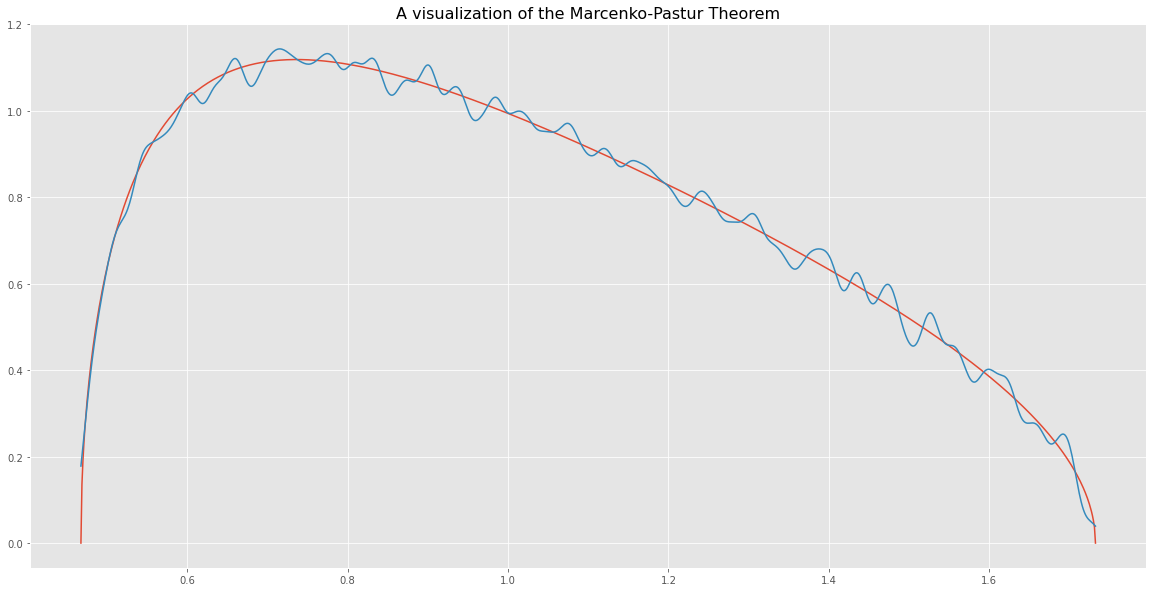

In [31]:
plt.plot(mp.eigen_values, pdf0)
plt.plot(mp.eigen_values, pdf1)
plt.title('A visualization of the Marcenko-Pastur Theorem', fontsize=16)


In [ ]:
def get_random_covariance(columns_number, facts_number):
    """
    Get a random covariance and add signal to it
    :param columns_number:
    :type columns_number:
    :param facts_number:
    :type facts_number:
    :return:
    :rtype:
    """
    w = np.random.normal(size=(columns_number, facts_number))
    covariance = np.dot(w, w.T)
    covariance += np.diag(np.random.uniform(size=columns_number))
    return covariance

def cov_to_corr(covariance):
    std = np.sqrt(np.diag(covariance))
    correlation = covariance/np.outer(std, std)
    correlation[correlation<-1], correlation[correlation>1] = -1, 1
    return correlation

In [6]:
alpha = 0.995
columns_number = 1000
facts_number = 100
q = 10

covariance = np.cov(np.random.normal(size=(columns_number*q, columns_number)), rowvar=False)
covariance = alpha*covariance + (1-alpha)*get_random_covariance(columns_number, facts_number)

corr0 = cov_to_corr(covariance)
eval0, evec0 = get_pca(corr0)

from scipy.optimize import minimize

def err_pdfs(var, eigenvalues, q, bandwidth, points=1000):
    pdf0 = mp_pdf(var, q, points)
    pdf1 = fit_kde(eigenvalues, bandwidth, x=pdf0.index.values)
    sse = np.sum((pdf1 - pdf0)**2)
    return sse

def find_max_eval(eigenvalues, q, bandwidth):
    out = minimize(lambda *x: err_pdfs(*x), 0.5, args=(eigenvalues, q, bandwidth),
                   bounds=((1E-5, 1-1E-5),))

    if out['success']:
        var = out['x'][0]
    else:
        var = 1
    eigen_max = var*(1+(1./q)**0.5)**2
    return eigen_max, var

emax0, var0 = find_max_eval(np.diag(eval0), q, bandwidth=0.01)
facts_number0 = eval0.shape[0] - np.diag(eval0)[::-1].searchsorted(emax0)

NameError: name 'mp_pdf' is not defined

In [ ]:
def denoised_corr(eigenvalues,eigenvector,facts_number):
# Remove noise from corr by fixing random eigenvalues
    eigenvalues_=np.diag(eigenvalues).copy()
    eigenvalues_[facts_number:]=eigenvalues_[facts_number:].sum()/float(eigenvalues_.shape[0]-facts_number)
    eigenvalues_=np.diag(eigenvalues_)
    corr=np.dot(eigenvalues,eigenvalues_).dot(eigenvector.T)
    corrç=cov_to_corr(corr)
    return corr1
#--------------------------------------------------- corr1=denoisedCorr(eVal0,eVec0,nFacts0) eVal1,eVec1=getPCA(corr1)

